##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Deep Convolutional Generative Adversarial Network

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/dcgan">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/dcgan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to generate images of handwritten digits using a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). The code is written using the [Keras Sequential API](https://www.tensorflow.org/guide/keras) with a `tf.GradientTape` training loop.

## What are GANs?
[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A *generator* ("the artist") learns to create images that look real, while a *discriminator* ("the art critic") learns to tell real images apart from fakes.

![A diagram of a generator and discriminator](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan1.png?raw=1)

During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator* becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.

![A second diagram of a generator and discriminator](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan2.png?raw=1)

This notebook demonstrates this process on the MNIST dataset. The following animation shows a series of images produced by the *generator* as it was trained for 50 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.

![sample output](https://tensorflow.org/images/gan/dcgan.gif)

To learn more about GANs, see MIT's [Intro to Deep Learning](http://introtodeeplearning.com/) course.

In [ ]:
#Connect to google drive
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


### Setup

In [ ]:
import tensorflow as tf
from datetime import datetime

In [ ]:
tf.__version__

'2.7.0'

In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-b_vhk7p1
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-b_vhk7p1
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=173555 sha256=85c4c09ce8eb0f7337ec02da4142918160b61336cb1aa307524e2268a8f0a68a
  Stored in directory: /tmp/pip-ephem-wheel-cache-t5812wmp/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [ ]:
#load dataset
%cd /content/gdrive/MyDrive/dataset/dataset_npy
train_images = np.load('myButterflies64.npy')
print(train_images.shape)

/content/gdrive/MyDrive/dataset/dataset_npy
(150, 64, 64, 3)


In [ ]:
#(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


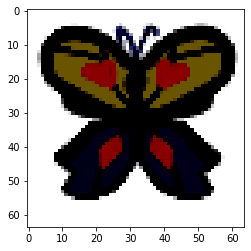

In [ ]:
plt.imshow(train_images[32])

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((4, 4, 512)))
    assert model.output_shape == (None, 4, 4, 512)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

Use the (as yet untrained) generator to create an image.

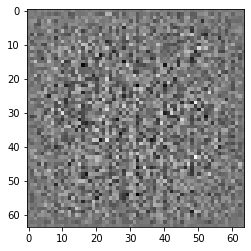

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-1.4572186e-05]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [ ]:
%cd /content/gdrive/MyDrive/ProjectOutput/GAN_TF/myButterflies/

/content/gdrive/MyDrive/ProjectOutput/GAN_TF/myButterflies


In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [ ]:
EPOCHS = 10000
noise_dim = 100
num_examples_to_generate = 9

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 100 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def train_noSave(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    if((epoch+1)%(int(epochs*25/100)) == 0 and epoch != 0):
      recordTime()
      generate_and_save_images(generator, epoch + 1, seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

**Generate and save images**


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  output_path = str(epoch)
  if not os.path.exists(output_path):
      os.makedirs(output_path)
  for i in range(9):
      plt.imshow((predictions[i]+1)/2)
      plt.axis('off')
      filename = 'epoch_%04d_%02d.png'%(epoch, i)
      name = os.path.join(output_path, filename)
      plt.savefig(name, bbox_inches = 'tight', pad_inches = 0)
      #pic = (predictions[i]+1)/2
      #pic.save(name)
      plt.close()

  #fig = plt.figure(figsize=(4, 4))
  fig = plt.figure(figsize=(3, 3))

  #for i in range(predictions.shape[0]):
  for i in range(9):
      plt.subplot(3, 3, i+1)
      #plt.imshow(predictions[i, :, :, :] * 127.5 + 127.5)
      plt.imshow((predictions[i]+1)/2)
      plt.axis('off')

  #now = datetime.now()
  #dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
  #plt.suptitle(dt_string)

  filename = 'image_at_epoch_{:04d}.png'.format(epoch)
  plt.savefig(filename, bbox_inches = 'tight', pad_inches = 0)
  plt.show()

#Time Record

In [ ]:
recording = []
def recordTime():
  recording.append(datetime.now())

In [ ]:
test_time = []
first_time = datetime.now()
test_time.append(first_time)

In [ ]:
later_time = datetime.now()
test_time.append(later_time)
difference = test_time[1] - test_time[0]

seconds_in_day = 24 * 60 * 60
divmod(difference.days * seconds_in_day + difference.seconds, 60)

(0, 3)

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

Time for epoch 1 is 2.4326746463775635 sec
Time for epoch 2 is 0.13082599639892578 sec
Time for epoch 3 is 0.12962937355041504 sec
Time for epoch 4 is 0.14214706420898438 sec
Time for epoch 5 is 0.11848974227905273 sec
Time for epoch 6 is 0.13064980506896973 sec
Time for epoch 7 is 0.15296196937561035 sec
Time for epoch 8 is 0.10714197158813477 sec
Time for epoch 9 is 0.1316666603088379 sec
Time for epoch 10 is 0.12773799896240234 sec
Time for epoch 11 is 0.13014912605285645 sec
Time for epoch 12 is 0.1304779052734375 sec
Time for epoch 13 is 0.12971878051757812 sec
Time for epoch 14 is 0.13002705574035645 sec
Time for epoch 15 is 0.13010430335998535 sec
Time for epoch 16 is 0.1296977996826172 sec
Time for epoch 17 is 0.13011956214904785 sec
Time for epoch 18 is 0.12960314750671387 sec
Time for epoch 19 is 0.13262033462524414 sec
Time for epoch 20 is 0.12882757186889648 sec
Time for epoch 21 is 0.13031697273254395 sec
Time for epoch 22 is 0.13024306297302246 sec
Time for epoch 23 is 0.

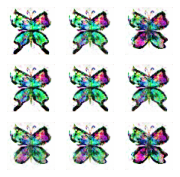

Time for epoch 2500 is 5.083531618118286 sec
Time for epoch 2501 is 0.10274481773376465 sec
Time for epoch 2502 is 0.13430094718933105 sec
Time for epoch 2503 is 0.13108396530151367 sec
Time for epoch 2504 is 0.13014602661132812 sec
Time for epoch 2505 is 0.1303110122680664 sec
Time for epoch 2506 is 0.13004159927368164 sec
Time for epoch 2507 is 0.1304478645324707 sec
Time for epoch 2508 is 0.13028931617736816 sec
Time for epoch 2509 is 0.15101909637451172 sec
Time for epoch 2510 is 0.1085062026977539 sec
Time for epoch 2511 is 0.1308274269104004 sec
Time for epoch 2512 is 0.12927961349487305 sec
Time for epoch 2513 is 0.13007497787475586 sec
Time for epoch 2514 is 0.13004851341247559 sec
Time for epoch 2515 is 0.12981033325195312 sec
Time for epoch 2516 is 0.13035964965820312 sec
Time for epoch 2517 is 0.13030529022216797 sec
Time for epoch 2518 is 0.13352727890014648 sec
Time for epoch 2519 is 0.12632536888122559 sec
Time for epoch 2520 is 0.12996745109558105 sec
Time for epoch 2521

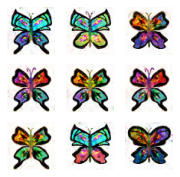

Time for epoch 5000 is 4.9087231159210205 sec
Time for epoch 5001 is 0.1125955581665039 sec
Time for epoch 5002 is 0.13326621055603027 sec
Time for epoch 5003 is 0.1362133026123047 sec
Time for epoch 5004 is 0.12459421157836914 sec
Time for epoch 5005 is 0.1303553581237793 sec
Time for epoch 5006 is 0.13016438484191895 sec
Time for epoch 5007 is 0.1352522373199463 sec
Time for epoch 5008 is 0.1244957447052002 sec
Time for epoch 5009 is 0.13017058372497559 sec
Time for epoch 5010 is 0.1296236515045166 sec
Time for epoch 5011 is 0.1306617259979248 sec
Time for epoch 5012 is 0.12906408309936523 sec
Time for epoch 5013 is 0.1299881935119629 sec
Time for epoch 5014 is 0.12937188148498535 sec
Time for epoch 5015 is 0.13000798225402832 sec
Time for epoch 5016 is 0.1303846836090088 sec
Time for epoch 5017 is 0.13030648231506348 sec
Time for epoch 5018 is 0.12963485717773438 sec
Time for epoch 5019 is 0.1299600601196289 sec
Time for epoch 5020 is 0.13011860847473145 sec
Time for epoch 5021 is 0

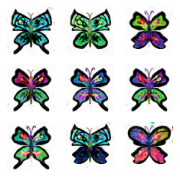

Time for epoch 7500 is 5.038982391357422 sec
Time for epoch 7501 is 0.10889554023742676 sec
Time for epoch 7502 is 0.1413118839263916 sec
Time for epoch 7503 is 0.13036441802978516 sec
Time for epoch 7504 is 0.13426446914672852 sec
Time for epoch 7505 is 0.1267409324645996 sec
Time for epoch 7506 is 0.13004326820373535 sec
Time for epoch 7507 is 0.12998485565185547 sec
Time for epoch 7508 is 0.12975454330444336 sec
Time for epoch 7509 is 0.1299450397491455 sec
Time for epoch 7510 is 0.12984371185302734 sec
Time for epoch 7511 is 0.12965917587280273 sec
Time for epoch 7512 is 0.13001513481140137 sec
Time for epoch 7513 is 0.12970972061157227 sec
Time for epoch 7514 is 0.1301431655883789 sec
Time for epoch 7515 is 0.13008713722229004 sec
Time for epoch 7516 is 0.12983155250549316 sec
Time for epoch 7517 is 0.13033032417297363 sec
Time for epoch 7518 is 0.1295633316040039 sec
Time for epoch 7519 is 0.13039398193359375 sec
Time for epoch 7520 is 0.13060259819030762 sec
Time for epoch 7521 

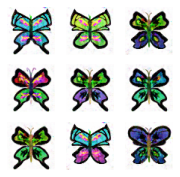

Time for epoch 10000 is 4.914155960083008 sec
/content/gdrive/MyDrive/ProjectOutput/TimeRecord
(5, 27)
(10, 58)
(16, 28)
(21, 58)


'./training_checkpoints/ckpt-1'

In [ ]:
recordTime()
train_noSave(train_dataset, EPOCHS)

#Save Record Time
#move to folder for save
%cd /content/gdrive/MyDrive/ProjectOutput/TimeRecord/

outputRecordName = 'myButterflies'
outputGANName = 'TF'

timeName = outputRecordName + '_' + outputGANName + '_TimeRecord.npy'
np.save(timeName, recording)

#calculate time difference
timeCal = []
for i in range(4):
  difference = recording[i+1] - recording[0]
  seconds_in_day = 24 * 60 * 60
  diff = divmod(difference.days * seconds_in_day + difference.seconds, 60)
  print(diff)
  timeCal.append(diff)

timeCalName = outputRecordName + '_' + outputGANName + '_TimeDiffRecord.npy'
np.save(timeCalName, timeCal)

checkpoint.save(file_prefix = checkpoint_prefix)

Restore the latest checkpoint.

In [ ]:
%cd /content/gdrive/MyDrive/ProjectOutput/GAN_dcganTF/butterflies_pictogram/

/content/gdrive/MyDrive/ProjectOutput/GAN_dcganTF/butterflies_pictogram


In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

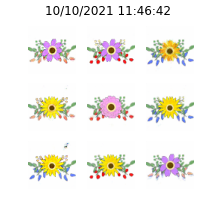

In [ ]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## Next steps


This tutorial has shown the complete code necessary to write and train a GAN. As a next step, you might like to experiment with a different dataset, for example the Large-scale Celeb Faces Attributes (CelebA) dataset [available on Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset). To learn more about GANs see the [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160).
